## Libraries

### Programming for Data Science (ID2214)

### Amir H. Rahnama (Twitter: @_ambodi)

#### Ph.D. Candidate 


<img src="https://www.kth.se/polopoly_fs/1.77259!/KTH_Logotyp_RGB_2013-2.svg" alt="kth_logo" style="width:200px;"/>

### Preface

In this lecture, we will be focusing on the use of libraries in our data science and Machine Learning projects. Just like the last lecture, our focus will be to solve the whole problem from the data gathering until modelling, so that you can have a grasp of how a *semi* real-world project works. 

The *outline* of this lecture are: 
* The Magic of Boosting Trees in practice
    * Sklearn's GradientBoostingClassifier
    * Xgboost's package
* A brief introduction to Artificial Neural Networks
    * What is an Artificial Neural Network? 
    * Training with Backpropagation
* How does XGBoost compare to a Multi-layer Perceptron? 
* Understanding how to wortk with Tensorflow and Keras
    * Modelling
    * Hyper-parameter Optimization
* Use GPUs in order to accelerate reading/manipulating/modelling of big chunks of data
    * Computation using GPU versions of Numpy and Pandas
    * Benchmarks on CPU/GPU version

### Gradient Boosting

According to Wikipedia, Gradient boosting is a machine learning technique for regression and classification problems, which produces a prediction model in the form of an ensemble of weak prediction models, typically decision trees. Gradient boosting is typically used with decision trees (especially CART trees) of a fixed size as base learners. 

In this lecture, we will be working with different implementation of Gradient Boosting. Like the previous lecture, we will continue with Scikit Learn. 

We will show you the Sklearn's implementation of Gradient Boosting, namely **sklearn.ensemble.GradientBoostingClassifier** and its limitations in terms of parallelization and performance.

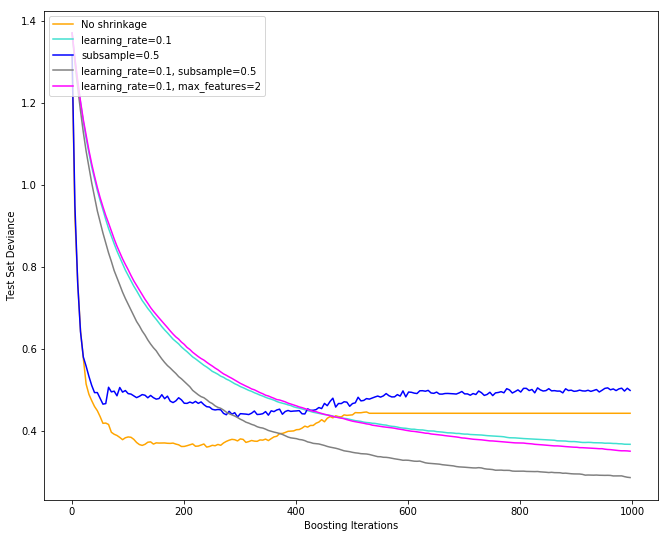

In [3]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import ensemble
from sklearn import datasets


X, y = datasets.make_hastie_10_2(n_samples=12000, random_state=1)
X = X.astype(np.float32)

# map labels from {-1, 1} to {0, 1}
labels, y = np.unique(y, return_inverse=True)

X_train, X_test = X[:2000], X[2000:]
y_train, y_test = y[:2000], y[2000:]

original_params = {'n_estimators': 1000, 'max_leaf_nodes': 4, 'max_depth': None, 'random_state': 2,
                   'min_samples_split': 5}

plt.figure(figsize=(11,9))

for label, color, setting in [('No shrinkage', 'orange',
                               {'learning_rate': 1.0, 'subsample': 1.0}),
                              ('learning_rate=0.1', 'turquoise',
                               {'learning_rate': 0.1, 'subsample': 1.0}),
                              ('subsample=0.5', 'blue',
                               {'learning_rate': 1.0, 'subsample': 0.5}),
                              ('learning_rate=0.1, subsample=0.5', 'gray',
                               {'learning_rate': 0.1, 'subsample': 0.5}),
                              ('learning_rate=0.1, max_features=2', 'magenta',
                               {'learning_rate': 0.1, 'max_features': 2})]:
    params = dict(original_params)
    params.update(setting)

    clf = ensemble.GradientBoostingClassifier(**params)
    clf.fit(X_train, y_train)

    # compute test set deviance
    test_deviance = np.zeros((params['n_estimators'],), dtype=np.float64)

    for i, y_pred in enumerate(clf.staged_decision_function(X_test)):
        # clf.loss_ assumes that y_test[i] in {0, 1}
        test_deviance[i] = clf.loss_(y_test, y_pred)

    plt.plot((np.arange(test_deviance.shape[0]) + 1)[::5], test_deviance[::5],
            '-', color=color, label=label)

plt.legend(loc='upper left')
plt.xlabel('Boosting Iterations')
plt.ylabel('Test Set Deviance')

plt.show()

### GPU-acceleration

In recent years, due to the huge growth in digitalizatio, a huge growth is digital footprint is visible. This increase has led to the use of larger computational powers to accelerate our computational power. These days, it is affordable to buy GPU units for our Personal Computers (PC) or even use cloud-based services. In this tutorial, I am using my PC's GPU unit.GPUs are all computational performances are very sensitive to the settings you are running them. You need to be at least careful regarding comparing approaches in at least three dimensions:

* Operating System (OS)
* Central processing unit (CPU) 
* Graphical processing unit (GPU)

Let us go through ways to check the information we are using in this tutorial: 

#### Operating System (OS)

In [1]:
!lsb_release -a

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.1 LTS
Release:	18.04
Codename:	bionic


#### Central Processing Unit

In [2]:
!cat /proc/cpuinfo  | grep 'name'| uniq

model name	: Intel(R) Core(TM) i7-7700K CPU @ 4.20GHz


#### Graphical Processing Unit

In order to get information about your GPU, you can run the following command in UBUNTU:

In [3]:
!lspci  -v -s  $(lspci | grep ' VGA ' | cut -d" " -f 1)

01:00.0 VGA compatible controller: NVIDIA Corporation GP104 [GeForce GTX 1080] (rev a1) (prog-if 00 [VGA controller])
	Subsystem: ASUSTeK Computer Inc. GP104 [GeForce GTX 1080]
	Flags: bus master, fast devsel, latency 0, IRQ 132
	Memory at de000000 (32-bit, non-prefetchable) [size=16M]
	Memory at c0000000 (64-bit, prefetchable) [size=256M]
	Memory at d0000000 (64-bit, prefetchable) [size=32M]
	I/O ports at e000 [size=128]
	[virtual] Expansion ROM at 000c0000 [disabled] [size=128K]
	Capabilities: <access denied>
	Kernel driver in use: nvidia
	Kernel modules: nvidiafb, nouveau, nvidia_drm, nvidia



You also need to check your GPU drivers, especially CUDA for this tutorial: 

In [4]:
! nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2017 NVIDIA Corporation
Built on Fri_Sep__1_21:08:03_CDT_2017
Cuda compilation tools, release 9.0, V9.0.176


### Numba

### Cupy

CuPy is an open-source matrix library accelerated with NVIDIA CUDA. It also uses CUDA-related libraries including cuBLAS, cuDNN, cuRand, cuSolver, cuSPARSE, cuFFT and NCCL to make full use of the GPU architecture. 

In [5]:
!pip install cupy-cuda90

You are using pip version 18.0, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
import numpy as np
import cupy as cp

#### Benchmarks: Numpy vs. Cupy

#### Matrix Multiplication

Let us build a case first for GPU enabled computation. Imagne you have two matrices and you would like to perform matrix multiplication, as we increase the size of the dimensions, we start to hit an issue: 

In [7]:
import time

time_per_dimension_cpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000, 20000, 50000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = np.random.rand(dim, dim)
    b = np.random.rand(dim, dim)
    c = np.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_cpu[dim] = end - start

Calcualting a Matrix for dim: 20
Calcualting a Matrix for dim: 50
Calcualting a Matrix for dim: 100
Calcualting a Matrix for dim: 500
Calcualting a Matrix for dim: 1000
Calcualting a Matrix for dim: 2000
Calcualting a Matrix for dim: 5000
Calcualting a Matrix for dim: 8000
Calcualting a Matrix for dim: 10000
Calcualting a Matrix for dim: 20000
Calcualting a Matrix for dim: 50000


MemoryError: 

A MemoryError hits us at 50000 as our initial dimension. Let us run the code once again with less dimensions: 

In [8]:
import time

time_per_dimension_cpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000, 20000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = np.random.rand(dim, dim)
    b = np.random.rand(dim, dim)
    c = np.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_cpu[dim] = end - start

Calcualting a Matrix for dim: 20
Calcualting a Matrix for dim: 50
Calcualting a Matrix for dim: 100
Calcualting a Matrix for dim: 500
Calcualting a Matrix for dim: 1000
Calcualting a Matrix for dim: 2000
Calcualting a Matrix for dim: 5000
Calcualting a Matrix for dim: 8000
Calcualting a Matrix for dim: 10000
Calcualting a Matrix for dim: 20000


Let us look at the result:

In [10]:
time_per_dimension_cpu

{20: 0.0004489421844482422,
 50: 0.0003826618194580078,
 100: 0.004021406173706055,
 500: 0.021151065826416016,
 1000: 0.06168174743652344,
 2000: 0.3888664245605469,
 5000: 5.342170715332031,
 8000: 19.003090620040894,
 10000: 36.48970103263855,
 20000: 290.3970561027527}

### Cupy

In [11]:
import time

time_per_dimension_gpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000, 20000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = cp.random.rand(dim, dim)
    b = cp.random.rand(dim, dim)
    c = cp.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_gpu[dim] = end - start

Calcualting a Matrix for dim: 20
Calcualting a Matrix for dim: 50
Calcualting a Matrix for dim: 100
Calcualting a Matrix for dim: 500
Calcualting a Matrix for dim: 1000
Calcualting a Matrix for dim: 2000
Calcualting a Matrix for dim: 5000
Calcualting a Matrix for dim: 8000
Calcualting a Matrix for dim: 10000
Calcualting a Matrix for dim: 20000


OutOfMemoryError: out of memory to allocate 3200000000 bytes (total 9600000000 bytes)

Okay so now we have come to realize one drawback of using GPU computations. In the CPU computation phase, after a MemoryError happened after 50000 as our initial dimension however in GPU computation with Cupy, due to the fact that GPUs have less memory, the OutOfMemoryError is happening at 2000. This is something that you need to know, although CPU compuations can be slower, CPU can have access to more memory, since they are cheaper and much more accessible. 

Let us run the code with less dimensions:

In [13]:
import time

time_per_dimension_gpu = {}
dimensions = [20, 50, 100, 500, 1000, 2000, 5000, 8000, 10000]

for dim in dimensions: 
    print('Calcualting a Matrix for dim: {}'.format(dim))
    
    start = time.time()
    
    a = cp.random.rand(dim, dim)
    b = cp.random.rand(dim, dim)
    c = cp.matmul(a, b)
    
    end = time.time()
    
    # Free up variables for garbage collector
    a = None
    b = None
    c = None
    
    time_per_dimension_gpu[dim] = end - start

Calcualting a Matrix for dim: 20
Calcualting a Matrix for dim: 50
Calcualting a Matrix for dim: 100
Calcualting a Matrix for dim: 500
Calcualting a Matrix for dim: 1000
Calcualting a Matrix for dim: 2000
Calcualting a Matrix for dim: 5000
Calcualting a Matrix for dim: 8000
Calcualting a Matrix for dim: 10000


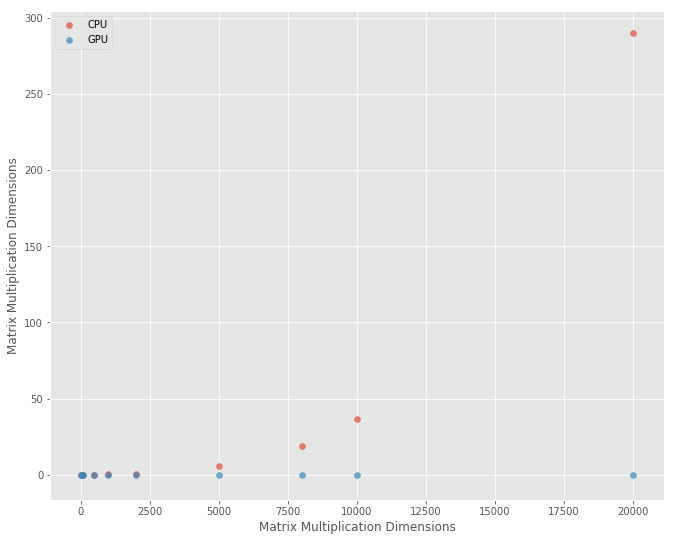

In [79]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')


fig, axs = plt.subplots(1, 1, figsize=(11, 9), sharey=True)
axs.scatter(time_per_dimension_cpu.keys(), time_per_dimension_cpu.values(), alpha=0.7, label='CPU')
axs.scatter(time_per_dimension_gpu.keys() , time_per_dimension_gpu.values(), alpha=0.7, label='GPU')

axs.legend()

axs.set_xlabel('Matrix Multiplication Dimensions')
axs.set_ylabel('Matrix Multiplication Dimensions')

plt.show()